In [1]:
import warnings
import sklearn.metrics as metrics
from utility import split_sequence, plot_history
from dataset import suny_international
warnings.filterwarnings("ignore")


In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [3]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import LSTM
from keras.layers import Dense,Input

Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

In [5]:
def vanilla_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
n_steps=20
n_features= 1
n_forward = 6

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [8]:
df=suny_international.load_data()['GHI']

In [9]:
y = df.resample('D').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

In [40]:
nas = decomposition.resid.isna() | decomposition.seasonal.isna() | decomposition.trend.isna() 
decomposition.resid= decomposition.resid[~nas]
decomposition.seasonal= decomposition.seasonal[~nas]
decomposition.trend= decomposition.trend[~nas]
y_true = decomposition.resid + decomposition.seasonal+ decomposition.trend
_,y_true_test = suny_international.train_test_split(y_true)


In [43]:
history = {}
model  = {}
components = ('seasonal','trend','resid')
y_pred = {}

seasonal 0.0030238853887729457


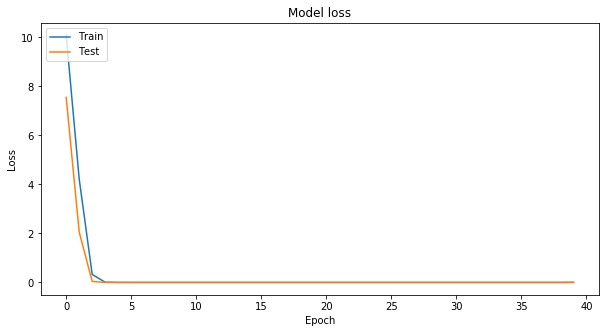

trend 1126.2817264636121


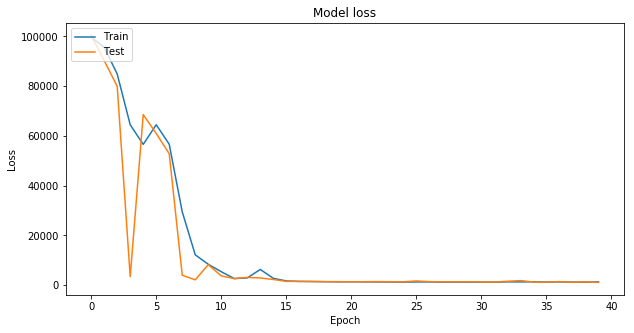

resid 1784.733698542111


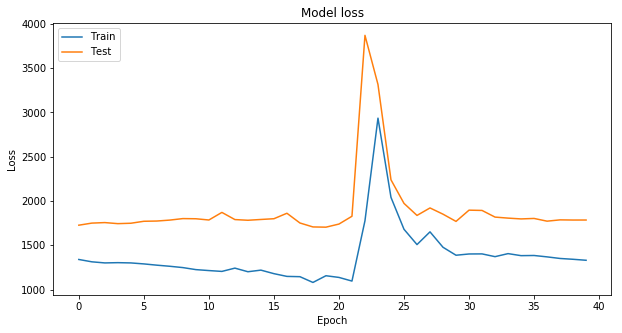

In [44]:
for component in components:
    df_train,df_test = suny_international.train_test_split(getattr(decomposition,component))
    
    X, y = split_sequence(df_train, n_steps,n_forward)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    X_val, y_val = split_sequence(df_test, n_steps,n_forward)
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

    model[component]=vanilla_lstm(n_steps, n_features)
    history[component] = model[component].fit(X,y,validation_data=(X_val,y_val),epochs=40,verbose=False)
    y_pred[component] = model[component].predict(X_val)
    model[component].save('models/simple_rnn_' + component + '.h5')
    print(component,history[component].history['val_loss'][-1])
    plot_history(history[component])   

In [45]:
y_pred_test = y_pred['seasonal'] + y_pred['trend'] + y_pred['resid']

In [46]:
metrics.mean_squared_error(y_true=y_true_test,y_pred=y_pred_test)

ValueError: Found input variables with inconsistent numbers of samples: [362, 337]

In [35]:
from keras.models import load_model
model_trend = load_model('models/simple_rnn_trend.h5')
model_seasonal = load_model('models/simple_rnn_seasonal.h5')
model_residual = load_model('models/simple_rnn_residual.h5')

In [36]:
df_test_trend = df_test_trend.dropna()
X, y = split_sequence(df_test_trend, n_steps)
Y_test = y
X = X.reshape((X.shape[0], X.shape[1], n_features))
trend_pred = model_trend.predict(X)

In [37]:
df_test_seasonal = df_test_seasonal.dropna()
X, y = split_sequence(df_test_seasonal, n_steps)
Y_test = Y_test + y
X = X.reshape((X.shape[0], X.shape[1], n_features))
seasonal_pred = model_seasonal.predict(X)


In [38]:
df_test_residual = df_test_residual.dropna()

X, y = split_sequence(df_test_residual, n_steps)
Y_test = Y_test + y
X = X.reshape((X.shape[0], X.shape[1], n_features))
residual_pred = model_residual.predict(X)
y.shape

(342,)

In [39]:
Y_test.shape
Y_predicted = trend_pred + seasonal_pred + residual_pred
Y_predicted.shape

(342, 1)

In [40]:
metrics.mean_squared_error(y_true=Y_test,y_pred=Y_predicted)

1017.1448255284606

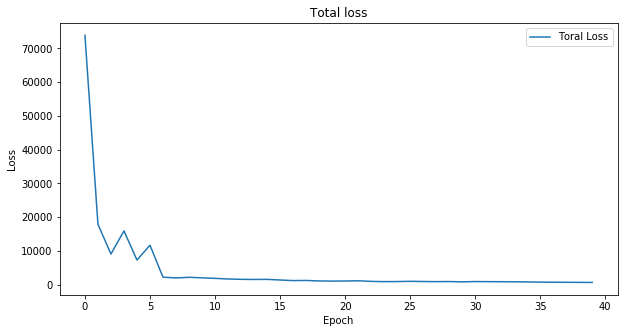

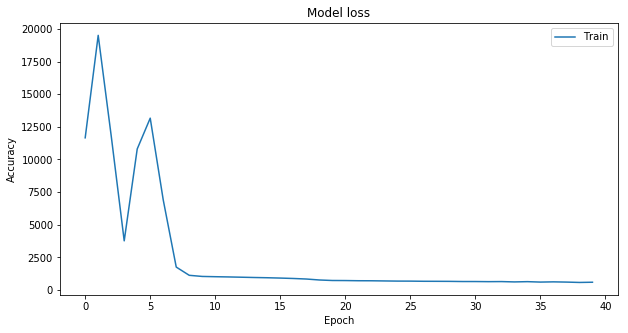

In [8]:
model=vanilla_lstm(n_steps, n_features)
history=model.fit(X,y,epochs=40,verbose=False)
model.save('models/simple_rnn.h5')
print(history.history['loss'][-1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
3440.1598347279205


In [9]:
X, y = split_sequence(df_test, n_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))
y_pred = model.predict(X)
metrics.mean_squared_error(y_true=y,y_pred=y_pred)

4296.363000494793

In [36]:
from keras.layers import concatenate

def lstm_with_weather(n_steps, n_features):
    temporal_input = Input(shape=(n_steps,1))
    lstm  = LSTM(50, activation='relu')(temporal_input)
    non_temporal_input =Input(shape=(n_features,))
    dense1 = Dense(units=20, activation='relu')(non_temporal_input) 
    all_info = concatenate(inputs=[lstm, dense1])
    dense3 = Dense(units=10, activation='relu')(all_info)
    output = Dense(units=1)(dense3)
    model = Model([temporal_input, non_temporal_input], output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [37]:
n_steps=20
n_features= len(suny_international.atmospheric_factors)

In [32]:
X_nontemporal=np.array([*(df_train[factor] for factor in suny_international.atmospheric_factors)]).T
X_nontemporal=X_nontemporal[n_steps:]
X_temporal, y = split_sequence(df_train['GHI'], n_steps)
X_temporal = X_temporal.reshape((X_temporal.shape[0], X_temporal.shape[1], 1))
X=[X_temporal,X_nontemporal]

In [38]:
model=lstm_with_weather(n_steps,n_features)
history=model.fit(X,y,epochs=40,verbose=False)
model.save('models/simple_rnn_atmospheric.h5')
print(history.history['loss'][-1])

Epoch 1/40
52588/52588 [==============================] - 46s 880us/step - loss: 16691.6269
Epoch 2/40
52588/52588 [==============================] - 47s 893us/step - loss: 4868.7353
Epoch 3/40
52588/52588 [==============================] - 44s 843us/step - loss: 3943.8434
Epoch 4/40
52588/52588 [==============================] - 39s 746us/step - loss: 3520.9397
Epoch 5/40
52588/52588 [==============================] - 43s 817us/step - loss: 3341.6771
Epoch 6/40
52588/52588 [==============================] - 37s 700us/step - loss: 3133.2629
Epoch 7/40
52588/52588 [==============================] - 34s 640us/step - loss: 3072.4762
Epoch 8/40
52588/52588 [==============================] - 37s 712us/step - loss: 3037.2125
Epoch 9/40
52588/52588 [==============================] - 39s 749us/step - loss: 3029.4447
Epoch 10/40
52588/52588 [==============================] - 46s 883us/step - loss: 3428.0865
Epoch 11/40
52588/52588 [==============================] - 46s 878us/step - loss: 2983.5

In [40]:
X_nontemporal=np.array([*(df_test[factor] for factor in suny_international.atmospheric_factors)]).T
X_nontemporal=X_nontemporal[n_steps:]
X_temporal, y = split_sequence(df_test['GHI'], n_steps)
X_temporal = X_temporal.reshape((X_temporal.shape[0], X_temporal.shape[1], 1))
X=[X_temporal,X_nontemporal]

In [41]:
y_pred = model.predict(X)
metrics.mean_squared_error(y_true=y,y_pred=y_pred)

2494.159641600965